<a href="https://colab.research.google.com/github/sreelathask1/PES_SEM4/blob/IMDB-Review/BERT_Classifier_Oscillatory_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloads the 'imdb-dataset-of-50k-movie-reviews' dataset using Kagglehub and prints the local path where the dataset files are stored.**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


**Sets up a DistilBERT model for IMDB sentiment classification, freezes the encoder layers for 'head-only' training, and compares the performance of OscillatingLR, AdamW, SGD, and RMSprop optimizers. It includes gradient accumulation and logs the last 30 steps' learning rates and losses for comparison.**

✅ Device: cpu
📦 Dataset: (5000, 2)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

🧾 MAX_LEN=128 | Train batches=250 | Test batches=63

🚀 Training head-only with OscillatingLR


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OscillatingLR | Epoch 1/3 | loss 0.6879 | acc 55.23%
OscillatingLR | Epoch 2/3 | loss 0.6645 | acc 64.03%
OscillatingLR | Epoch 3/3 | loss 0.6361 | acc 70.30%

🚀 Training head-only with AdamW


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AdamW | Epoch 1/3 | loss 0.6936 | acc 50.88%
AdamW | Epoch 2/3 | loss 0.6930 | acc 51.67%
AdamW | Epoch 3/3 | loss 0.6937 | acc 50.80%

🚀 Training head-only with SGD


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SGD | Epoch 1/3 | loss 0.6927 | acc 51.25%
SGD | Epoch 2/3 | loss 0.6925 | acc 50.70%
SGD | Epoch 3/3 | loss 0.6923 | acc 52.23%

🚀 Training head-only with RMSprop


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RMSprop | Epoch 1/3 | loss 0.6969 | acc 48.55%
RMSprop | Epoch 2/3 | loss 0.6975 | acc 47.30%
RMSprop | Epoch 3/3 | loss 0.6970 | acc 47.33%


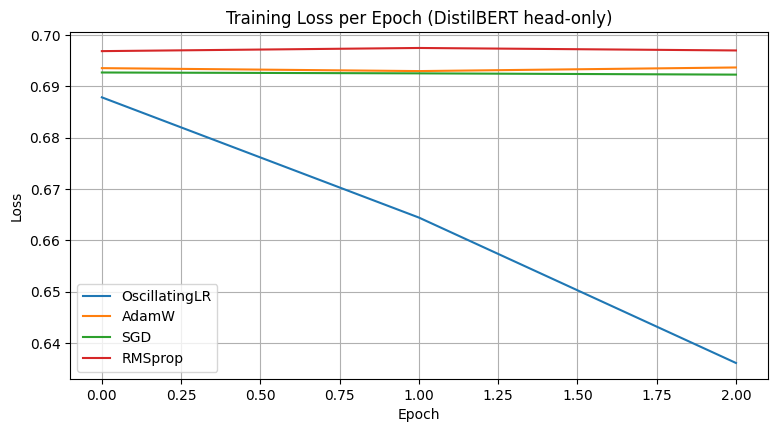

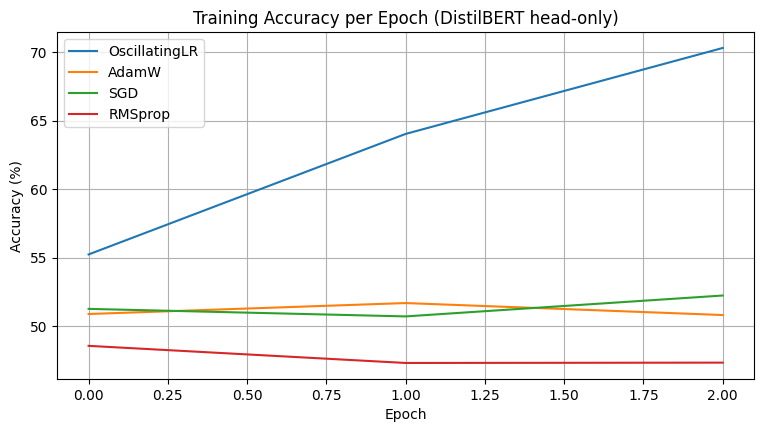

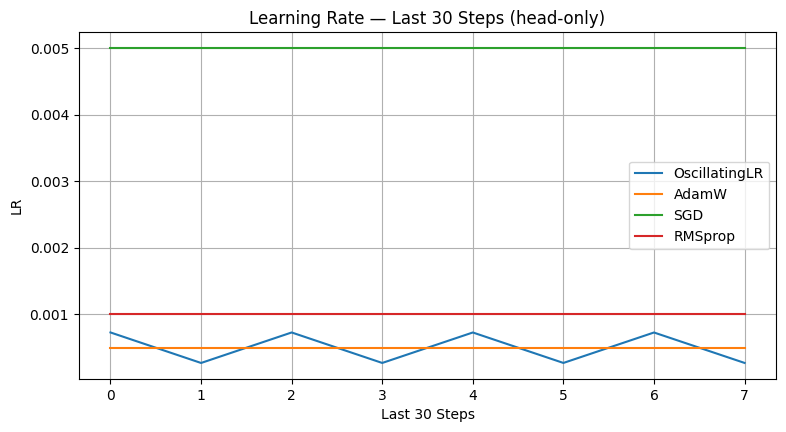

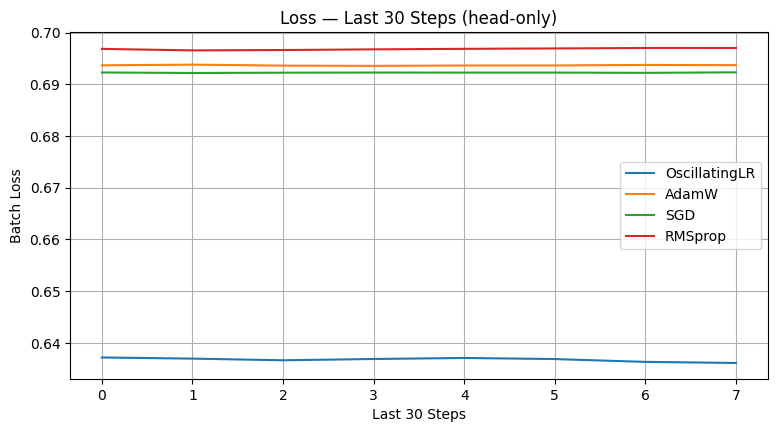


🏁 Final Test Accuracy:
OscillatingLR: 73.90%
AdamW: 51.80%
SGD: 52.70%
RMSprop: 49.60%


In [ ]:
# ============================================================
# IMDB Sentiment (5k balanced) — DistilBERT (CPU Turbo)
# Classifier-only training (encoder frozen)
# Optimizer comparison: OscillatingLR vs AdamW vs SGD vs RMSprop
# Logs last 30 steps (LR + Loss) and plots LR/Loss comparisons
# ============================================================

import os, re, random, math, time, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# ---------- install transformers if missing ----------
try:
    import transformers
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "transformers==4.44.2", "accelerate>=0.33.0"])
    import transformers

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    np.random.seed(seed); random.seed(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# ----------------------------
# Load IMDB CSV (Kaggle path), sample 5k (2.5k+2.5k)
# ----------------------------
kaggle_path = "/kaggle/input/imdb-dataset-of-50k-movie-reviews"
csv_file_path = os.path.join(kaggle_path, "IMDB Dataset.csv")
assert os.path.exists(csv_file_path), "IMDB CSV not found at Kaggle path."

df_full = pd.read_csv(csv_file_path)
df_pos = df_full[df_full["sentiment"]=="positive"].sample(2500, random_state=42)
df_neg = df_full[df_full["sentiment"]=="negative"].sample(2500, random_state=42)
df = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)
print("📦 Dataset:", df.shape)

# ----------------------------
# Clean text (keep apostrophes for contractions)
# ----------------------------
_tok_re = re.compile(r"[^a-zA-Z\s']+")
def clean_text(t: str) -> str:
    t = str(t).lower()
    t = _tok_re.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["clean"] = df["review"].fillna("").apply(clean_text)
labels_np = (df["sentiment"] == "positive").astype(int).values  # 1=pos, 0=neg

# ----------------------------
# Tokenize (fast), shorter seq for CPU
# ----------------------------
MAX_LEN = 128
BATCH = 16
ACC_STEPS = 4  # gradient accumulation (effective batch = 64)
EPOCHS = 3     # CPU-friendly; increase if time allows

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
enc = tokenizer(
    df["clean"].tolist(),
    truncation=True,
    padding="max_length",
    max_length=MAX_LEN,
    return_tensors="pt"
)
input_ids = enc["input_ids"]
attention_mask = enc["attention_mask"]
labels_t = torch.tensor(labels_np, dtype=torch.long)

# ----------------------------
# Dataset & Dataloaders
# ----------------------------
class IMDBBertDS(Dataset):
    def __init__(self, ids, mask, labels):
        self.ids = ids; self.mask = mask; self.labels = labels
    def __len__(self): return self.ids.size(0)
    def __getitem__(self, i):
        return {
            "input_ids": self.ids[i],
            "attention_mask": self.mask[i],
            "labels": self.labels[i]
        }

dataset = IMDBBertDS(input_ids, attention_mask, labels_t)
train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

print(f"🧾 MAX_LEN={MAX_LEN} | Train batches={len(train_loader)} | Test batches={len(test_loader)}")

# ----------------------------
# Model factory (freeze encoder — classifier-only training)
# ----------------------------
def make_model():
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=2
    )
    # freeze the encoder
    for p in model.distilbert.parameters():
        p.requires_grad = False
    # Typically train pre_classifier, dropout, and classifier
    trainable = []
    for p in model.pre_classifier.parameters():
        p.requires_grad = True; trainable.append(p)
    for p in model.classifier.parameters():
        p.requires_grad = True; trainable.append(p)
    # (dropout has no params)
    return model.to(device)

def get_trainable_params(model):
    params = []
    params += list(model.pre_classifier.parameters())
    params += list(model.classifier.parameters())
    return params

# ----------------------------
# Custom OscillatingLR (gentle; head-only)
# ----------------------------
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=5e-4, oscillation_factor=2.5e-4, momentum=0.98, decay=5e-4):
        self.base_lr, self.osc, self.momentum = base_lr, oscillation_factor, momentum
        self.decay, self.step_count = decay, 0
        super().__init__(params, dict(momentum=momentum))
        for g in self.param_groups:
            for p in g['params']:
                self.state[p] = {'velocity': torch.zeros_like(p)}

    def step(self, closure=None):
        self.step_count += 1
        decay = 1.0 / (1.0 + self.decay * self.step_count)
        lr = self.base_lr + self.osc * decay * (1 if self.step_count % 2 == 0 else -1)
        for g in self.param_groups:
            m = g['momentum']
            for p in g['params']:
                if p.grad is not None:
                    v = self.state[p]['velocity']
                    v.mul_(m).add_(p.grad)
                    p.data -= lr * v
                    self.state[p]['velocity'] = v
        return lr

# ----------------------------
# Train / Eval (with gradient accumulation & last-30-steps logging)
# ----------------------------
def train_one(model, optimizer, epochs=EPOCHS, name="OPT"):
    model.train()
    loss_hist, acc_hist = [], []
    ce = nn.CrossEntropyLoss()

    steps_per_epoch = len(train_loader)
    total_steps = epochs * steps_per_epoch
    step_global = 0
    last30_logs = []

    optimizer_is_osc = isinstance(optimizer, OscillatingLR)

    for ep in range(epochs):
        running_loss = correct = total = 0
        optimizer.zero_grad()
        for i, batch in enumerate(train_loader):
            step_global += 1

            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            y = batch["labels"].to(device)

            out = model(**inputs)
            loss = ce(out.logits, y) / ACC_STEPS
            loss.backward()

            # Gradient accumulation update
            lr_val = None
            if (i + 1) % ACC_STEPS == 0 or (i + 1) == steps_per_epoch:
                lr_val = optimizer.step() if optimizer_is_osc else optimizer.param_groups[0]['lr']
                optimizer.zero_grad()

            running_loss += float(loss.item()) * ACC_STEPS  # unscale for logging
            pred = out.logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

            # Log last 30 global steps (based on optimizer updates)
            # Only log when an optimizer step actually happened (after accumulation)
            if lr_val is not None and step_global > (total_steps - 30):
                last30_logs.append({"step": step_global, "lr": float(lr_val), "loss": float(running_loss/(i+1))})

        ep_loss = running_loss / steps_per_epoch
        ep_acc  = 100 * correct / total
        loss_hist.append(ep_loss); acc_hist.append(ep_acc)
        print(f"{name} | Epoch {ep+1}/{epochs} | loss {ep_loss:.4f} | acc {ep_acc:.2f}%")

    return loss_hist, acc_hist, last30_logs

@torch.no_grad()
def evaluate(model):
    model.eval()
    total = correct = 0
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        y = batch["labels"].to(device)
        out = model(**inputs)
        pred = out.logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100 * correct / total

# ----------------------------
# Build + run all optimizers (head-only params)
# ----------------------------
def make_optimizer(name, params):
    if name == "OscillatingLR":
        return OscillatingLR(params, base_lr=5e-4, oscillation_factor=2.5e-4, momentum=0.98, decay=5e-4)
    if name == "AdamW":
        return optim.AdamW(params, lr=5e-4)  # head-only can afford higher LR
    if name == "SGD":
        return optim.SGD(params, lr=5e-3, momentum=0.9)
    if name == "RMSprop":
        return optim.RMSprop(params, lr=1e-3)
    raise ValueError(name)

optimizers_to_try = ["OscillatingLR", "AdamW", "SGD", "RMSprop"]

results = {}
last30 = {}

for opt_name in optimizers_to_try:
    print("\n" + "="*68)
    print(f"🚀 Training head-only with {opt_name}")
    model = make_model()
    head_params = get_trainable_params(model)
    optimizer = make_optimizer(opt_name, head_params)
    losses, accs, logs = train_one(model, optimizer, epochs=EPOCHS, name=opt_name)
    test_acc = evaluate(model)
    results[opt_name] = {"loss": losses, "acc": accs, "test": test_acc}
    last30[opt_name] = logs

# ----------------------------
# Plots: Loss/Acc per epoch
# ----------------------------
plt.figure(figsize=(9,4.5))
for name in results: plt.plot(results[name]["loss"], label=name)
plt.title("Training Loss per Epoch (DistilBERT head-only)"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(9,4.5))
for name in results: plt.plot(results[name]["acc"], label=name)
plt.title("Training Accuracy per Epoch (DistilBERT head-only)"); plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.grid(True); plt.show()

# ----------------------------
# Last-30: LR comparison (Oscillating zig-zag + flat for others)
# ----------------------------
plt.figure(figsize=(9,4.5))
for name, logs in last30.items():
    lrs = [d["lr"] for d in logs]
    if len(lrs) > 0:
        plt.plot(range(len(lrs)), lrs, label=name)
plt.title("Learning Rate — Last 30 Steps (head-only)"); plt.xlabel("Last 30 Steps"); plt.ylabel("LR"); plt.legend(); plt.grid(True); plt.show()

# ----------------------------
# Last-30: Loss comparison
# ----------------------------
plt.figure(figsize=(9,4.5))
for name, logs in last30.items():
    losses_ = [d["loss"] for d in logs]
    if len(losses_) > 0:
        plt.plot(range(len(losses_)), losses_, label=name)
plt.title("Loss — Last 30 Steps (head-only)"); plt.xlabel("Last 30 Steps"); plt.ylabel("Batch Loss"); plt.legend(); plt.grid(True); plt.show()

print("\n🏁 Final Test Accuracy:")
for name in results:
    print(f"{name}: {results[name]['test']:.2f}%")


**Optimizer comparison for DistilBERT head-only training. This time, it uses an equal learning rate (1e-3) for all optimizers and provides more detailed per-step logging of loss and learning rate for granular analysis.**

✅ Device: cpu
Available samples: pos=25000, neg=25000
📦 Sampled dataset shape: (5000, 2)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

🧾 Train batches=250 | Test batches=63

🚀 Training with OscillatingLR (lr=1e-3)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OscillatingLR | Step 0025 | Epoch 1 | Loss 0.7344 | LR 0.000506
OscillatingLR | Step 0050 | Epoch 1 | Loss 0.6869 | LR 0.001488
OscillatingLR | Step 0075 | Epoch 1 | Loss 0.6051 | LR 0.000518
OscillatingLR | Step 0100 | Epoch 1 | Loss 0.5693 | LR 0.001476
OscillatingLR | Step 0125 | Epoch 1 | Loss 0.5992 | LR 0.000529
OscillatingLR | Step 0150 | Epoch 1 | Loss 0.6123 | LR 0.001465
OscillatingLR | Step 0175 | Epoch 1 | Loss 0.5379 | LR 0.000540
OscillatingLR | Step 0200 | Epoch 1 | Loss 0.6876 | LR 0.001455
OscillatingLR | Step 0225 | Epoch 1 | Loss 0.4947 | LR 0.000551
OscillatingLR | Step 0250 | Epoch 1 | Loss 0.5153 | LR 0.001444
OscillatingLR | Step 0275 | Epoch 2 | Loss 0.4937 | LR 0.000560
OscillatingLR | Step 0300 | Epoch 2 | Loss 0.5882 | LR 0.001435
OscillatingLR | Step 0325 | Epoch 2 | Loss 0.4354 | LR 0.000570
OscillatingLR | Step 0350 | Epoch 2 | Loss 0.3853 | LR 0.001426
OscillatingLR | Step 0375 | Epoch 2 | Loss 0.5889 | LR 0.000579
OscillatingLR | Step 0400 | Epoch 2 | Lo

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AdamW | Step 0025 | Epoch 1 | Loss 0.6176 | LR 0.001000
AdamW | Step 0050 | Epoch 1 | Loss 0.7340 | LR 0.001000
AdamW | Step 0075 | Epoch 1 | Loss 0.6944 | LR 0.001000
AdamW | Step 0100 | Epoch 1 | Loss 0.5606 | LR 0.001000
AdamW | Step 0125 | Epoch 1 | Loss 0.5878 | LR 0.001000
AdamW | Step 0150 | Epoch 1 | Loss 0.3361 | LR 0.001000
AdamW | Step 0175 | Epoch 1 | Loss 0.2604 | LR 0.001000
AdamW | Step 0200 | Epoch 1 | Loss 0.8086 | LR 0.001000
AdamW | Step 0225 | Epoch 1 | Loss 0.5404 | LR 0.001000
AdamW | Step 0250 | Epoch 1 | Loss 0.3130 | LR 0.001000
AdamW | Step 0275 | Epoch 2 | Loss 0.5720 | LR 0.001000
AdamW | Step 0300 | Epoch 2 | Loss 0.5900 | LR 0.001000
AdamW | Step 0325 | Epoch 2 | Loss 0.2032 | LR 0.001000
AdamW | Step 0350 | Epoch 2 | Loss 0.5355 | LR 0.001000
AdamW | Step 0375 | Epoch 2 | Loss 0.9287 | LR 0.001000
AdamW | Step 0400 | Epoch 2 | Loss 0.4179 | LR 0.001000
AdamW | Step 0425 | Epoch 2 | Loss 0.5881 | LR 0.001000
AdamW | Step 0450 | Epoch 2 | Loss 0.2744 | LR 0

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SGD | Step 0025 | Epoch 1 | Loss 0.6801 | LR 0.001000
SGD | Step 0050 | Epoch 1 | Loss 0.6801 | LR 0.001000
SGD | Step 0075 | Epoch 1 | Loss 0.6904 | LR 0.001000
SGD | Step 0100 | Epoch 1 | Loss 0.6978 | LR 0.001000
SGD | Step 0125 | Epoch 1 | Loss 0.6825 | LR 0.001000
SGD | Step 0150 | Epoch 1 | Loss 0.7024 | LR 0.001000
SGD | Step 0175 | Epoch 1 | Loss 0.7053 | LR 0.001000
SGD | Step 0200 | Epoch 1 | Loss 0.6843 | LR 0.001000
SGD | Step 0225 | Epoch 1 | Loss 0.6692 | LR 0.001000
SGD | Step 0250 | Epoch 1 | Loss 0.6885 | LR 0.001000
SGD | Step 0275 | Epoch 2 | Loss 0.6722 | LR 0.001000
SGD | Step 0300 | Epoch 2 | Loss 0.6554 | LR 0.001000
SGD | Step 0325 | Epoch 2 | Loss 0.6586 | LR 0.001000
SGD | Step 0350 | Epoch 2 | Loss 0.6772 | LR 0.001000
SGD | Step 0375 | Epoch 2 | Loss 0.6900 | LR 0.001000
SGD | Step 0400 | Epoch 2 | Loss 0.6756 | LR 0.001000
SGD | Step 0425 | Epoch 2 | Loss 0.6810 | LR 0.001000
SGD | Step 0450 | Epoch 2 | Loss 0.6802 | LR 0.001000
SGD | Step 0475 | Epoch 2 | 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RMSprop | Step 0025 | Epoch 1 | Loss 0.4718 | LR 0.001000
RMSprop | Step 0050 | Epoch 1 | Loss 0.5383 | LR 0.001000
RMSprop | Step 0075 | Epoch 1 | Loss 0.4772 | LR 0.001000
RMSprop | Step 0100 | Epoch 1 | Loss 0.4074 | LR 0.001000
RMSprop | Step 0125 | Epoch 1 | Loss 0.6117 | LR 0.001000
RMSprop | Step 0150 | Epoch 1 | Loss 0.4116 | LR 0.001000
RMSprop | Step 0175 | Epoch 1 | Loss 0.4307 | LR 0.001000
RMSprop | Step 0200 | Epoch 1 | Loss 0.4757 | LR 0.001000
RMSprop | Step 0225 | Epoch 1 | Loss 0.5298 | LR 0.001000
RMSprop | Step 0250 | Epoch 1 | Loss 0.2975 | LR 0.001000
RMSprop | Step 0275 | Epoch 2 | Loss 0.3040 | LR 0.001000
RMSprop | Step 0300 | Epoch 2 | Loss 0.4514 | LR 0.001000
RMSprop | Step 0325 | Epoch 2 | Loss 0.7303 | LR 0.001000
RMSprop | Step 0350 | Epoch 2 | Loss 0.5894 | LR 0.001000
RMSprop | Step 0375 | Epoch 2 | Loss 0.4253 | LR 0.001000
RMSprop | Step 0400 | Epoch 2 | Loss 0.2221 | LR 0.001000
RMSprop | Step 0425 | Epoch 2 | Loss 0.6086 | LR 0.001000
RMSprop | Step

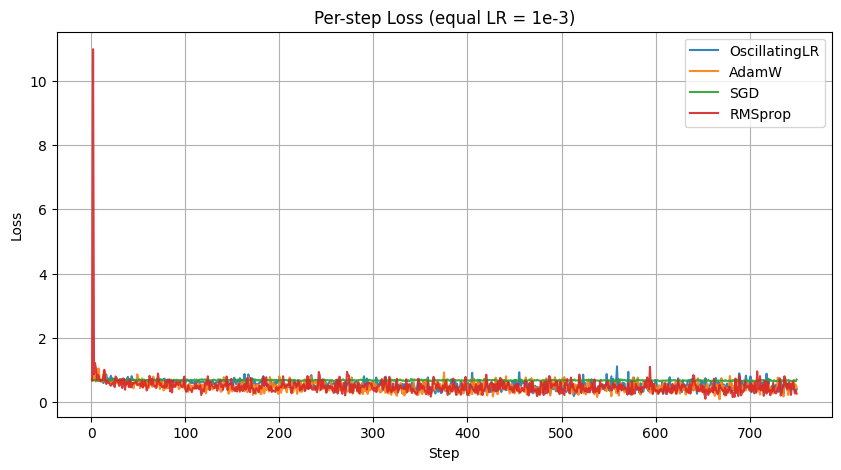

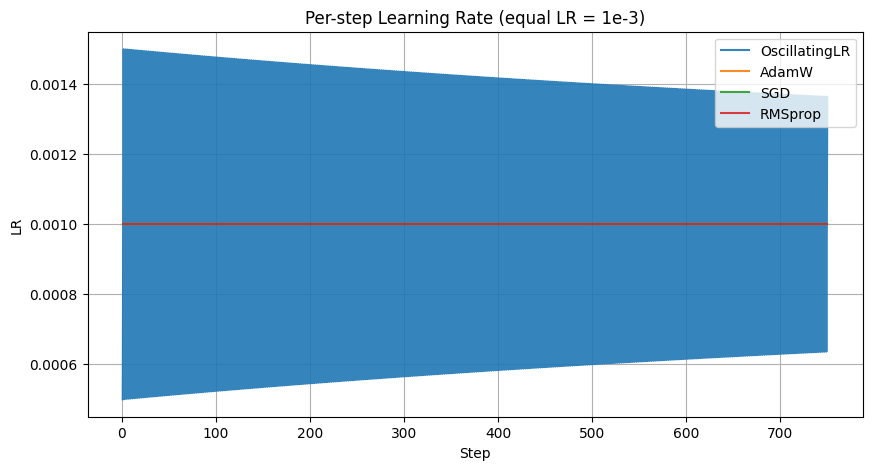


🏁 Final Test Accuracies:
OscillatingLR: 77.30%
AdamW: 80.60%
SGD: 72.90%
RMSprop: 81.20%


In [ ]:
# ============================================================
# Fixed: IMDB 5k balanced sample + DistilBERT head-only
# Equal LR comparison (1e-3) with per-step logging (every step)
# Optimizers: OscillatingLR, AdamW, SGD, RMSprop
# ============================================================

import os, re, random, sys, subprocess, time
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Install transformers if missing
try:
    import transformers
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "transformers==4.44.2", "accelerate>=0.33.0"])
    import transformers

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed); random.seed(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# ----------------------------
# Load IMDB (Kaggle) and sample 5k (2.5k pos + 2.5k neg)
# ----------------------------
kaggle_path = "/kaggle/input/imdb-dataset-of-50k-movie-reviews"
csv_file_path = os.path.join(kaggle_path, "IMDB Dataset.csv")
if not os.path.exists(csv_file_path):
    raise FileNotFoundError(f"IMDB CSV not found at: {csv_file_path}")

df_full = pd.read_csv(csv_file_path)

# Ensure expected columns exist
assert "review" in df_full.columns and "sentiment" in df_full.columns, "CSV must contain 'review' and 'sentiment' columns"

# Count available positives/negatives
pos_count = (df_full["sentiment"] == "positive").sum()
neg_count = (df_full["sentiment"] == "negative").sum()
print(f"Available samples: pos={pos_count}, neg={neg_count}")

# Desired per-class sample
per_class = 2500
if pos_count < per_class or neg_count < per_class:
    raise ValueError(f"Not enough samples to form {per_class}+{per_class}. Found pos={pos_count}, neg={neg_count}")

df_pos = df_full[df_full["sentiment"] == "positive"].sample(per_class, random_state=42)
df_neg = df_full[df_full["sentiment"] == "negative"].sample(per_class, random_state=42)
df = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)
print("📦 Sampled dataset shape:", df.shape)

# ----------------------------
# Clean text (keep apostrophes)
# ----------------------------
_tok_re = re.compile(r"[^a-zA-Z\s']+")
def clean_text(t):
    t = str(t).lower()
    t = _tok_re.sub(" ", t)
    return re.sub(r"\s+", " ", t).strip()

df["clean"] = df["review"].fillna("").apply(clean_text)
labels_np = (df["sentiment"] == "positive").astype(int).values

# ----------------------------
# Tokenize (shorter seq for CPU)
# ----------------------------
MAX_LEN = 128
BATCH = 16
EPOCHS = 3

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
enc = tokenizer(df["clean"].tolist(), truncation=True, padding="max_length",
                max_length=MAX_LEN, return_tensors="pt")

class IMDBBertDS(Dataset):
    def __init__(self, ids, mask, labels):
        self.ids, self.mask, self.labels = ids, mask, labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {"input_ids": self.ids[i],
                "attention_mask": self.mask[i],
                "labels": self.labels[i]}

dataset = IMDBBertDS(enc["input_ids"], enc["attention_mask"], torch.tensor(labels_np))
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False)

print(f"🧾 Train batches={len(train_loader)} | Test batches={len(test_loader)}")

# ----------------------------
# Model factory (encoder frozen)
# ----------------------------
def make_model():
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=2
    )
    for p in model.distilbert.parameters():
        p.requires_grad = False
    # Ensure classifier/pre_classifier are trainable
    for p in model.pre_classifier.parameters():
        p.requires_grad = True
    for p in model.classifier.parameters():
        p.requires_grad = True
    return model.to(device)

def get_trainable_params(model):
    return list(model.pre_classifier.parameters()) + list(model.classifier.parameters())

# ----------------------------
# OscillatingLR (same LR base)
# ----------------------------
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=1e-3, oscillation_factor=5e-4, momentum=0.98, decay=5e-4):
        self.base_lr, self.osc, self.momentum = base_lr, oscillation_factor, momentum
        self.decay, self.step_count = decay, 0
        super().__init__(params, dict(momentum=momentum))
        for g in self.param_groups:
            for p in g['params']:
                self.state[p] = {'velocity': torch.zeros_like(p)}
    def step(self, closure=None):
        self.step_count += 1
        decay = 1/(1 + self.decay * self.step_count)
        lr = self.base_lr + self.osc * decay * (1 if self.step_count % 2 == 0 else -1)
        for g in self.param_groups:
            m = g['momentum']
            for p in g['params']:
                if p.grad is not None:
                    v = self.state[p]['velocity']
                    v.mul_(m).add_(p.grad)
                    p.data -= lr * v
                    self.state[p]['velocity'] = v
        return lr

# ----------------------------
# Train & eval with per-step logging
# ----------------------------
def train_eval(name, optimizer_class, lr=1e-3):
    model = make_model()
    params = get_trainable_params(model)
    # instantiate optimizer
    if optimizer_class == OscillatingLR:
        optimizer = optimizer_class(params, base_lr=lr)
    else:
        # AdamW accepts lr keyword; for other built-ins, this works too
        optimizer = optimizer_class(params, lr=lr)

    ce = nn.CrossEntropyLoss()
    logs = []
    step = 0

    for epoch in range(EPOCHS):
        model.train()
        for i, batch in enumerate(train_loader):
            step += 1
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            y = batch["labels"].to(device)

            optimizer.zero_grad()
            out = model(**inputs)
            loss = ce(out.logits, y)
            loss.backward()

            # step
            if isinstance(optimizer, OscillatingLR):
                lr_now = optimizer.step()
            else:
                optimizer.step()
                lr_now = optimizer.param_groups[0]["lr"]

            logs.append({"step": step, "epoch": epoch+1, "loss": float(loss.item()), "lr": float(lr_now)})

            # optional console progress
            if step % 25 == 0:
                print(f"{name} | Step {step:04d} | Epoch {epoch+1} | Loss {loss.item():.4f} | LR {lr_now:.6f}")

    # evaluation
    model.eval(); correct=total=0
    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            y = batch["labels"].to(device)
            out = model(**inputs)
            pred = out.logits.argmax(dim=1)
            correct += (pred==y).sum().item(); total += y.size(0)
    acc = 100 * correct / total
    print(f"\n✅ {name} Test Accuracy: {acc:.2f}%\n")
    return pd.DataFrame(logs), acc

# ----------------------------
# Run all optimizers with equal LR
# ----------------------------
optimizers = {
    "OscillatingLR": OscillatingLR,
    "AdamW": optim.AdamW,
    "SGD": optim.SGD,
    "RMSprop": optim.RMSprop
}

logs_all = {}
accs = {}
for name, opt_class in optimizers.items():
    print("\n" + "="*70)
    print(f"🚀 Training with {name} (lr=1e-3)")
    df_logs, acc = train_eval(name, opt_class, lr=1e-3)
    logs_all[name] = df_logs
    accs[name] = acc

# ----------------------------
# Plots: per-step loss & LR
# ----------------------------
plt.figure(figsize=(10,5))
for name, df in logs_all.items():
    plt.plot(df["step"], df["loss"], label=name, alpha=0.9)
plt.title("Per-step Loss (equal LR = 1e-3)"); plt.xlabel("Step"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,5))
for name, df in logs_all.items():
    plt.plot(df["step"], df["lr"], label=name, alpha=0.9)
plt.title("Per-step Learning Rate (equal LR = 1e-3)"); plt.xlabel("Step"); plt.ylabel("LR"); plt.legend(); plt.grid(True); plt.show()

print("\n🏁 Final Test Accuracies:")
for name, acc in accs.items():
    print(f"{name}: {acc:.2f}%")


**Explores fine-tuning of the DistilBERT model by unfreezing the last two encoder layers along with the classifier layers. It continues the optimizer comparison using an equal learning rate (1e-3) and logs per-step loss and learning rate.**

✅ Device: cpu
📦 Dataset: (5000, 2)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]


🚀 Fine-tuning with OscillatingLR (lr=1e-3)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OscillatingLR | Step 0050 | Epoch 1 | Loss 0.6849 | LR 0.00100488
OscillatingLR | Step 0100 | Epoch 1 | Loss 0.6548 | LR 0.00100476
OscillatingLR | Step 0150 | Epoch 1 | Loss 0.6634 | LR 0.00100465
OscillatingLR | Step 0200 | Epoch 1 | Loss 0.6762 | LR 0.00100455
OscillatingLR | Step 0250 | Epoch 1 | Loss 0.6263 | LR 0.00100444
OscillatingLR | Step 0300 | Epoch 2 | Loss 0.6772 | LR 0.00100435
OscillatingLR | Step 0350 | Epoch 2 | Loss 0.5713 | LR 0.00100426
OscillatingLR | Step 0400 | Epoch 2 | Loss 0.5767 | LR 0.00100417
OscillatingLR | Step 0450 | Epoch 2 | Loss 0.4989 | LR 0.00100408
OscillatingLR | Step 0500 | Epoch 2 | Loss 0.5822 | LR 0.00100400
OscillatingLR | Step 0550 | Epoch 3 | Loss 0.5732 | LR 0.00100392
OscillatingLR | Step 0600 | Epoch 3 | Loss 0.6550 | LR 0.00100385
OscillatingLR | Step 0650 | Epoch 3 | Loss 0.5282 | LR 0.00100377
OscillatingLR | Step 0700 | Epoch 3 | Loss 0.6445 | LR 0.00100370
OscillatingLR | Step 0750 | Epoch 3 | Loss 0.5498 | LR 0.00100364

✅ Oscilla

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AdamW | Step 0050 | Epoch 1 | Loss 0.6963 | LR 0.00100000
AdamW | Step 0100 | Epoch 1 | Loss 0.6895 | LR 0.00100000
AdamW | Step 0150 | Epoch 1 | Loss 0.7112 | LR 0.00100000
AdamW | Step 0200 | Epoch 1 | Loss 0.6973 | LR 0.00100000
AdamW | Step 0250 | Epoch 1 | Loss 0.6779 | LR 0.00100000
AdamW | Step 0300 | Epoch 2 | Loss 0.6897 | LR 0.00100000
AdamW | Step 0350 | Epoch 2 | Loss 0.6865 | LR 0.00100000
AdamW | Step 0400 | Epoch 2 | Loss 0.6800 | LR 0.00100000
AdamW | Step 0450 | Epoch 2 | Loss 0.6737 | LR 0.00100000
AdamW | Step 0500 | Epoch 2 | Loss 0.6960 | LR 0.00100000
AdamW | Step 0550 | Epoch 3 | Loss 0.7028 | LR 0.00100000
AdamW | Step 0600 | Epoch 3 | Loss 0.6858 | LR 0.00100000
AdamW | Step 0650 | Epoch 3 | Loss 0.6872 | LR 0.00100000
AdamW | Step 0700 | Epoch 3 | Loss 0.6920 | LR 0.00100000
AdamW | Step 0750 | Epoch 3 | Loss 0.6952 | LR 0.00100000

✅ AdamW Test Accuracy: 51.80%


🚀 Fine-tuning with RMSprop (lr=1e-3)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RMSprop | Step 0050 | Epoch 1 | Loss 0.6802 | LR 0.00100000
RMSprop | Step 0100 | Epoch 1 | Loss 0.7029 | LR 0.00100000
RMSprop | Step 0150 | Epoch 1 | Loss 0.7003 | LR 0.00100000
RMSprop | Step 0200 | Epoch 1 | Loss 0.6960 | LR 0.00100000
RMSprop | Step 0250 | Epoch 1 | Loss 0.6977 | LR 0.00100000
RMSprop | Step 0300 | Epoch 2 | Loss 0.6803 | LR 0.00100000
RMSprop | Step 0350 | Epoch 2 | Loss 0.6936 | LR 0.00100000
RMSprop | Step 0400 | Epoch 2 | Loss 0.6881 | LR 0.00100000
RMSprop | Step 0450 | Epoch 2 | Loss 0.6924 | LR 0.00100000
RMSprop | Step 0500 | Epoch 2 | Loss 0.7019 | LR 0.00100000
RMSprop | Step 0550 | Epoch 3 | Loss 0.6868 | LR 0.00100000
RMSprop | Step 0600 | Epoch 3 | Loss 0.6968 | LR 0.00100000
RMSprop | Step 0650 | Epoch 3 | Loss 0.6933 | LR 0.00100000
RMSprop | Step 0700 | Epoch 3 | Loss 0.6817 | LR 0.00100000
RMSprop | Step 0750 | Epoch 3 | Loss 0.7239 | LR 0.00100000

✅ RMSprop Test Accuracy: 52.70%


🚀 Fine-tuning with SGD (lr=1e-3)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SGD | Step 0050 | Epoch 1 | Loss 0.7243 | LR 0.00100000
SGD | Step 0100 | Epoch 1 | Loss 0.7091 | LR 0.00100000
SGD | Step 0150 | Epoch 1 | Loss 0.6929 | LR 0.00100000
SGD | Step 0200 | Epoch 1 | Loss 0.6983 | LR 0.00100000
SGD | Step 0250 | Epoch 1 | Loss 0.7086 | LR 0.00100000
SGD | Step 0300 | Epoch 2 | Loss 0.6994 | LR 0.00100000
SGD | Step 0350 | Epoch 2 | Loss 0.7052 | LR 0.00100000
SGD | Step 0400 | Epoch 2 | Loss 0.6915 | LR 0.00100000
SGD | Step 0450 | Epoch 2 | Loss 0.7002 | LR 0.00100000
SGD | Step 0500 | Epoch 2 | Loss 0.6919 | LR 0.00100000
SGD | Step 0550 | Epoch 3 | Loss 0.7001 | LR 0.00100000
SGD | Step 0600 | Epoch 3 | Loss 0.7147 | LR 0.00100000
SGD | Step 0650 | Epoch 3 | Loss 0.7141 | LR 0.00100000
SGD | Step 0700 | Epoch 3 | Loss 0.7065 | LR 0.00100000
SGD | Step 0750 | Epoch 3 | Loss 0.6942 | LR 0.00100000

✅ SGD Test Accuracy: 49.60%



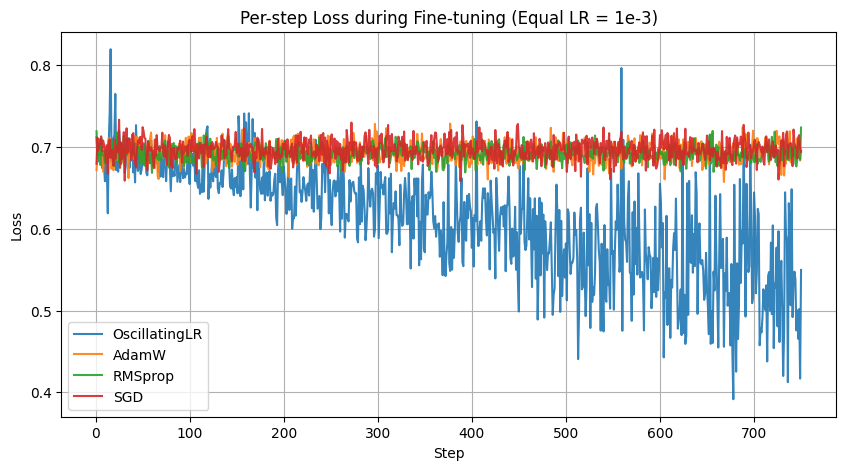

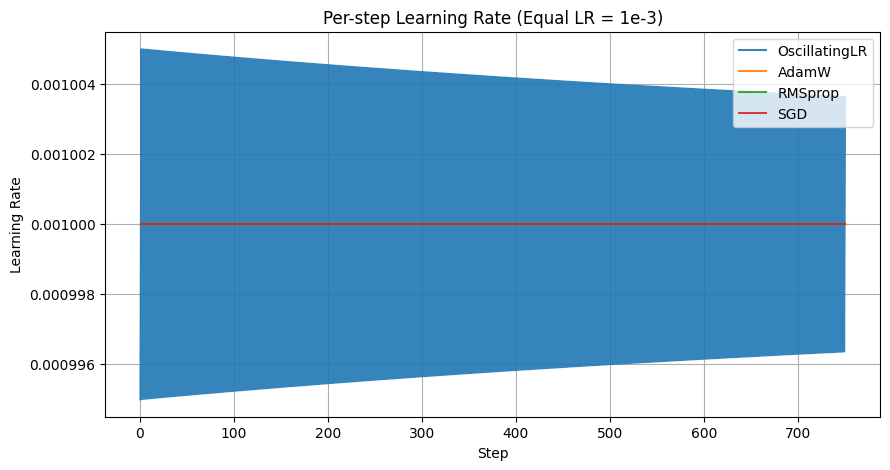


🏁 Final Test Accuracies:
OscillatingLR: 76.20%
AdamW: 51.80%
RMSprop: 52.70%
SGD: 49.60%


In [ ]:
  # ============================================================
# IMDB Fine-Tuning with DistilBERT (Last 2 Layers Unfrozen)
# Optimizer Comparison with Equal LR = 2e-5
# Logs every 50 steps | 3 Epochs
# ============================================================

import os, re, random, sys, subprocess, time
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Install transformers if missing
try:
    import transformers
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "transformers==4.44.2"])
    import transformers

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed); random.seed(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# ----------------------------
# Load IMDB 5k balanced subset
# ----------------------------
kaggle_path = "/kaggle/input/imdb-dataset-of-50k-movie-reviews"
csv_file_path = os.path.join(kaggle_path, "IMDB Dataset.csv")
assert os.path.exists(csv_file_path), "IMDB dataset not found!"

df_full = pd.read_csv(csv_file_path)
df_pos = df_full[df_full["sentiment"]=="positive"].sample(2500, random_state=42)
df_neg = df_full[df_full["sentiment"]=="negative"].sample(2500, random_state=42)
df = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)
print("📦 Dataset:", df.shape)

# ----------------------------
# Clean and tokenize
# ----------------------------
_tok_re = re.compile(r"[^a-zA-Z\s']+")
def clean_text(t):
    t = str(t).lower()
    t = _tok_re.sub(" ", t)
    return re.sub(r"\s+", " ", t).strip()

df["clean"] = df["review"].apply(clean_text)
labels_np = (df["sentiment"] == "positive").astype(int).values

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
enc = tokenizer(df["clean"].tolist(), truncation=True, padding="max_length",
                max_length=128, return_tensors="pt")

class IMDBDataset(Dataset):
    def __init__(self, ids, mask, labels):
        self.ids, self.mask, self.labels = ids, mask, labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {"input_ids": self.ids[i],
                "attention_mask": self.mask[i],
                "labels": self.labels[i]}

dataset = IMDBDataset(enc["input_ids"], enc["attention_mask"], torch.tensor(labels_np))
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

# ----------------------------
# Model factory (unfreeze last 2 encoder layers)
# ----------------------------
def make_model():
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=2
    )
    # Unfreeze last 2 transformer layers
    for name, param in model.distilbert.named_parameters():
        param.requires_grad = any(f"transformer.layer.{i}" in name for i in [-1, -2])
    # Ensure classifier layers trainable
    for p in model.pre_classifier.parameters():
        p.requires_grad = True
    for p in model.classifier.parameters():
        p.requires_grad = True
    return model.to(device)

# ----------------------------
# OscillatingLR definition
# ----------------------------
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=1e-3, oscillation_factor=5e-6, momentum=0.9, decay=0.0005):
        self.base_lr, self.osc, self.momentum = base_lr, oscillation_factor, momentum
        self.decay, self.step_count = decay, 0
        super().__init__(params, dict(momentum=momentum))
        for g in self.param_groups:
            for p in g['params']:
                self.state[p] = {'velocity': torch.zeros_like(p)}
    def step(self, closure=None):
        self.step_count += 1
        decay = 1/(1 + self.decay * self.step_count)
        lr = self.base_lr + self.osc * decay * (1 if self.step_count % 2 == 0 else -1)
        for g in self.param_groups:
            m = g['momentum']
            for p in g['params']:
                if p.grad is not None:
                    v = self.state[p]['velocity']
                    v.mul_(m).add_(p.grad)
                    p.data -= lr * v
                    self.state[p]['velocity'] = v
        return lr

# ----------------------------
# Train & evaluate
# ----------------------------
def train_eval(name, optimizer_class, lr=1e-3, log_every=50):
    model = make_model()
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optimizer_class(params, base_lr=lr) if optimizer_class == OscillatingLR else optimizer_class(params, lr=lr)
    ce = nn.CrossEntropyLoss()
    logs = []
    step = 0
    EPOCHS = 3

    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, batch in enumerate(train_loader):
            step += 1
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            y = batch["labels"].to(device)

            optimizer.zero_grad()
            out = model(**inputs)
            loss = ce(out.logits, y)
            loss.backward()

            lr_now = optimizer.step() if isinstance(optimizer, OscillatingLR) else optimizer.param_groups[0]["lr"]
            logs.append({"step": step, "epoch": epoch+1, "loss": loss.item(), "lr": lr_now})

            if step % log_every == 0:
                print(f"{name} | Step {step:04d} | Epoch {epoch+1} | Loss {loss.item():.4f} | LR {lr_now:.8f}")

    # Evaluation
    model.eval(); correct=total=0
    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            y = batch["labels"].to(device)
            out = model(**inputs)
            pred = out.logits.argmax(dim=1)
            correct += (pred==y).sum().item()
            total += y.size(0)
    acc = 100 * correct / total
    print(f"\n✅ {name} Test Accuracy: {acc:.2f}%\n")
    return pd.DataFrame(logs), acc

# ----------------------------
# Run all optimizers
# ----------------------------
optimizers = {
    "OscillatingLR": OscillatingLR,
    "AdamW": optim.AdamW,
    "RMSprop": optim.RMSprop,
    "SGD": optim.SGD
}

logs_all, accs = {}, {}
for name, opt_class in optimizers.items():
    print("\n" + "="*70)
    print(f"🚀 Fine-tuning with {name} (lr=1e-3)")
    logs, acc = train_eval(name, opt_class, lr=1e-3)
    logs_all[name] = logs
    accs[name] = acc

# ----------------------------
# Plot results
# ----------------------------
plt.figure(figsize=(10,5))
for name, df in logs_all.items():
    plt.plot(df["step"], df["loss"], label=name, alpha=0.9)
plt.title("Per-step Loss during Fine-tuning (Equal LR = 1e-3)")
plt.xlabel("Step"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,5))
for name, df in logs_all.items():
    plt.plot(df["step"], df["lr"], label=name, alpha=0.9)
plt.title("Per-step Learning Rate (Equal LR = 1e-3)")
plt.xlabel("Step"); plt.ylabel("Learning Rate"); plt.legend(); plt.grid(True); plt.show()

print("\n🏁 Final Test Accuracies:")
for name, acc in accs.items():
    print(f"{name}: {acc:.2f}%")